In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import string
import numpy as np
from numpy import array
import glob
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from PIL import Image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from pickle import dump, load
from time import time
import pickle
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras import Input, layers
from keras import optimizers
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text


In [0]:
def load_desc():
    df = pd.read_csv('/content/drive/My Drive/Project minor/project/results.csv', delimiter='|')
    description = dict()
    for i in df.values:
        id = i[0].split('.')[0]
        if id not in description.keys():
            description[id] = [i[2]]
        else:
            description[id].append(i[2])
    return description
descriptions = load_desc()

In [0]:
list(descriptions.keys())[:4]

['1000092795', '10002456', '1000268201', '1000344755']

In [0]:
descriptions['1000092795']

[' Two young guys with shaggy hair look at their hands while hanging out in the yard .',
 ' Two young , White males are outside near many bushes .',
 ' Two men in green shirts are standing in a yard .',
 ' A man in a blue shirt standing in a garden .',
 ' Two friends enjoy time spent together .']

In [0]:
descriptions['10002456']

[' Several men in hard hats are operating a giant pulley system .',
 ' Workers look down from up above on a piece of equipment .',
 ' Two men working on a machine wearing hard hats .',
 ' Four men on top of a tall structure .',
 ' Three men on a large rig .']

In [0]:
descriptions['1000268201']

[' A child in a pink dress is climbing up a set of stairs in an entry way .',
 ' A little girl in a pink dress going into a wooden cabin .',
 ' A little girl climbing the stairs to her playhouse .',
 ' A little girl climbing into a wooden playhouse ',
 ' A girl going into a wooden building .']

In [0]:
descriptions['1000344755']

[' Someone in a blue shirt and hat is standing on stair and leaning against a window .',
 ' A man in a blue shirt is standing on a ladder cleaning a window .',
 ' A man on a ladder cleans the window of a tall building .',
 ' man in blue shirt and jeans on ladder cleaning windows',
 ' a man on a ladder cleans a window']

In [0]:
def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i] 
            desc = str(desc)
            desc = desc.split()  #tokenizing
            desc = [word.lower() for word in desc] # convert to lower case
            desc = [w.translate(table) for w in desc] # remove punctuation from each token
            desc = [word for word in desc if len(word)>1] # remove hanging 's' and 'a'
            desc = [word for word in desc if word.isalpha()] # remove tokens with numbers in them
            desc_list[i] =  ' '.join(desc) # store as string
clean_descriptions(descriptions)

In [0]:
descriptions['1000092795']

['two young guys with shaggy hair look at their hands while hanging out in the yard',
 'two young white males are outside near many bushes',
 'two men in green shirts are standing in yard',
 'man in blue shirt standing in garden',
 'two friends enjoy time spent together']

In [0]:
descriptions['10002456']

['several men in hard hats are operating giant pulley system',
 'workers look down from up above on piece of equipment',
 'two men working on machine wearing hard hats',
 'four men on top of tall structure',
 'three men on large rig']

In [0]:
descriptions['1000268201']

['child in pink dress is climbing up set of stairs in an entry way',
 'little girl in pink dress going into wooden cabin',
 'little girl climbing the stairs to her playhouse',
 'little girl climbing into wooden playhouse',
 'girl going into wooden building']

In [0]:
descriptions['1000344755']

['someone in blue shirt and hat is standing on stair and leaning against window',
 'man in blue shirt is standing on ladder cleaning window',
 'man on ladder cleans the window of tall building',
 'man in blue shirt and jeans on ladder cleaning windows',
 'man on ladder cleans window']

In [0]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):

    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 19735


In [0]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [0]:
images = 'flickr30k_images/flickr30k_images/'
img = glob.glob(images + '*.jpg')

In [0]:
train_img,test_img = train_test_split(list(descriptions.keys()),test_size=0.1, random_state=1)
train_img, valid_img = train_test_split(train_img,test_size=0.1, random_state=1)

In [0]:
print(len(train_img), len(test_img), len(valid_img))

25743 3179 2861


In [0]:
def load_clean_descriptions(filename, dataset):

    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'): # split line by white space
        tokens = line.split() # split id from description
        image_id, image_desc = tokens[0], tokens[1:] # skip images not in the set
        
        if image_id in dataset: # create list
            if image_id not in descriptions:
                descriptions[image_id] = list() # wrap description in tokens
            
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            
            descriptions[image_id].append(desc)
    return descriptions

train_descriptions = load_clean_descriptions('/content/drive/My Drive/Project minor/project/descriptions.txt', train_img)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=25743


In [0]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299)) # Convert all the images to size 299x299 as expected by the inception v3 model
    x = image.img_to_array(img) # Convert PIL image to numpy array of 3-dimensions
    x = np.expand_dims(x, axis=0) # Add one more dimension
    x = preprocess_input(x) # preprocess the images using preprocess_input() from inception module
    return x

In [0]:
model = InceptionV3(weights= 'imagenet') # Load the inception v3 model
model_new = Model(model.input, model.layers[-2].output) # Create a new model, by removing the last layer (output layer) from the inception v3









96116736/96112376 [==============================] - 9s 0us/step


In [0]:
def encode(image): # Function to encode a given image into a vector of size (2048, )
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [0]:
def path_add(dataset):
    for i in range(len(dataset)):
        dataset[i] = 'flickr30k_images/flickr30k_images/' + dataset[i] + '.jpg'
    return dataset

In [0]:
train_img = path_add(train_img)

In [0]:
# funtion to encode all the train images time stamps for cpu
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 6186.933167219162


In [0]:
# Save the bottleneck train features to disk
with open("pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [0]:
test_img = path_add(test_img)

In [0]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 816.2759296894073


In [0]:
# Save the bottleneck test features to disk
with open("pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [0]:
valid_img = path_add(valid_img)

In [0]:
# Call the funtion to encode all the validation set images - Execute this only once
start = time()
encoding_valid = {}
for img in valid_img:
    encoding_valid[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 1413.2124264240265


In [0]:
# Save the bottleneck test features to disk
with open("pickle/encoded_valid_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_valid, encoded_pickle)

In [0]:
train_features = load(open("/content/drive/My Drive/Project minor/project/pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=25743


In [0]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

128715

In [0]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 18109 -> 4900


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [0]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

4901

In [0]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 74


In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [0]:
#load glove vetors
embeddings_index = {} # empty dictionary
f = open('/content/drive/My Drive/Project minor/project/glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix.shape

(4901, 200)

In [0]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 74)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 74, 200)      980200      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
model.layers[2]

In [0]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
epochs = 20
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [0]:

for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/My Drive/Project minor/project/model/' + str(i) + '.h5')

Epoch 1/1
8581/8581 [==============================] - 1984s 231ms/step - loss: 4.1983
Epoch 1/1
8581/8581 [==============================] - 1963s 229ms/step - loss: 3.6883
Epoch 1/1
8581/8581 [==============================] - 1928s 225ms/step - loss: 3.5677
Epoch 1/1
8581/8581 [==============================] - 1960s 228ms/step - loss: 3.5122
Epoch 1/1
8581/8581 [==============================] - 2005s 234ms/step - loss: 3.4776
Epoch 1/1
8581/8581 [==============================] - 1981s 231ms/step - loss: 3.4574
Epoch 1/1
8581/8581 [==============================] - 1989s 232ms/step - loss: 3.4436
Epoch 1/1
1755/8581 [=====>........................] - ETA: 26:00 - loss: 3.3951Buffered data was truncated after reaching the output size limit.

In [0]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [0]:

for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
4290/4290 [==============================] - 1053s 245ms/step - loss: 5.0073
Epoch 1/1
4290/4290 [==============================] - 1053s 245ms/step - loss: 5.0073
Epoch 1/1
4290/4290 [==============================] - 1062s 248ms/step - loss: 4.2616
Epoch 1/1
Epoch 1/1
4290/4290 [==============================] - 1060s 247ms/step - loss: 4.0067
Epoch 1/1
Epoch 1/1
4290/4290 [==============================] - 1046s 244ms/step - loss: 3.8610
Epoch 1/1
Epoch 1/1
4290/4290 [==============================] - 1038s 242ms/step - loss: 3.7608
Epoch 1/1
Epoch 1/1
4290/4290 [==============================] - 1042s 243ms/step - loss: 3.6859
Epoch 1/1
Epoch 1/1
4290/4290 [==============================] - 1029s 240ms/step - loss: 3.6254
Epoch 1/1
Epoch 1/1
4290/4290 [==============================] - 1054s 246ms/step - loss: 3.5754
Epoch 1/1
Epoch 1/1
4290/4290 [==============================] - 1048s 244ms/step - loss: 3.5325
Epoch 1/1
Epoch 1/1
4290/4290 [=============================

In [0]:
model.save_weights('/content/drive/My Drive/Project minor/project/model_30.h5')

In [0]:
model.load_weights('/content/drive/My Drive/Project minor/project/model_30.h5')

In [0]:
def textSearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [0]:
def captioning(path_image):
    image = encode(path_image)
    img = plt.imread(path_image)
    plt.imshow(img)
    x = image.reshape((1,2048))
    return textSearch(x)

In [0]:
import json

with open('/content/drive/My Drive/Project minor/project/data.json', 'w') as fp:
    json.dump(wordtoix, fp)

'group of people are walking down the street'

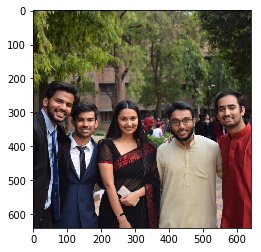

In [0]:
captioning('/content/drive/My Drive/Project minor/project/pp (1).jpeg')

'group of people are riding bicycles in the street'

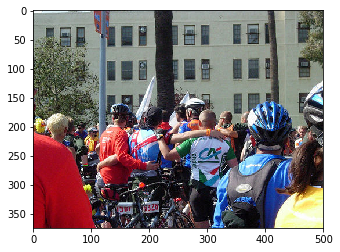

In [0]:
captioning('/content/drive/My Drive/Project minor/project/19469520.jpg')

'woman in black jacket and sunglasses is sitting on the sidewalk'

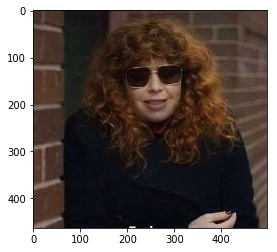

In [0]:
captioning('/content/drive/My Drive/Project minor/project/f2d9cf66-f15d-417d-9009-afd8f9573bd2.jpeg')